In [4]:
! pip install scikit-plot

In [0]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
import os
import cv2
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from keras import backend as K
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
np.random.seed(42)

In [0]:
import shutil
from zipfile import ZipFile 

def zip_extractor(data):
    try:
        shutil.rmtree(data)
    except Exception:
        pass

    file_name = f"drive/My Drive/FER/datasets/{data}.zip"

    with ZipFile(file_name, 'r') as zip_:
        print('Extracting all the files...') 
        zip_.extractall(data)
        print('Done!')

In [11]:
DATA = "fer_aligned"
BASE_PATH = "drive/My Drive/FER/Colab/GauravSharma/DCNN/"

if "fer" in DATA:
    if DATA == "fer":
        zip_extractor(DATA)
        DATA_PATH = "fer/final/"
    else:
        zip_extractor(DATA)
        DATA_PATH = f"{DATA}/{DATA}/"
    TOP_EMOTIONS = ["Happy", "Neutral", "Sadness"]
    TRAIN_SIZE = 0.88
else:
    zip_extractor(DATA)
    DATA_PATH = f"{DATA}/{DATA}/"
    TOP_EMOTIONS = ["Happy", "Fear", "Sadness", "Surprise", "Anger"]
    TRAIN_SIZE = 0.75

INPUT_SHAPE = (48,48,1)
NUM_CLASSES = len(TOP_EMOTIONS)

Extracting all the files...
Done!


In [12]:
class_count = {}
for dir_ in os.listdir(DATA_PATH):
    if not dir_.isupper():
        os.rename(DATA_PATH+dir_, DATA_PATH+dir_.title())
        dir_ = dir_.title()

    count = 0
    for f in os.listdir(DATA_PATH + dir_ + "/"):
        count += 1

    class_count[dir_] = count
    print(f"{dir_} has {count} number of images")

total_images = sum(class_count.values())
print(f"\ntotal images are {total_images}")

Angry has 789 number of images
Fear has 649 number of images
Happy has 1927 number of images
Sadness has 1051 number of images
Neutral has 1209 number of images

total images are 5625


In [13]:
for k,v in class_count.items():
    if not k in TOP_EMOTIONS:
        total_images -= v

total_images

4187

In [14]:
img_arr = np.empty(shape=(total_images, *INPUT_SHAPE))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
label = 0
for dir_ in os.listdir(DATA_PATH):

    if dir_ in TOP_EMOTIONS:
        label_to_text[label] = dir_
        for f in os.listdir(DATA_PATH + dir_ + "/"):
            img_arr[i] = np.expand_dims(cv2.imread(DATA_PATH + dir_ + "/" + f, 0), axis=2)
            img_label[i] = label
            i += 1

        print(f"loaded {dir_} images to numpy arrays...")
        label += 1

img_label = np_utils.to_categorical(img_label)
img_arr.shape, img_label.shape

loaded Happy images to numpy arrays...
loaded Sadness images to numpy arrays...
loaded Neutral images to numpy arrays...


((4187, 48, 48, 1), (4187, 3))

In [15]:
label_to_text

{0: 'Happy', 1: 'Sadness', 2: 'Neutral'}

In [16]:
text_to_label = dict((v,k) for k,v in label_to_text.items())
text_to_label

{'Happy': 0, 'Neutral': 2, 'Sadness': 1}

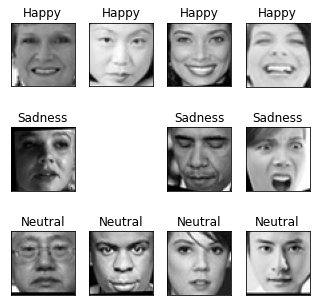

In [17]:
num_emotions = len(TOP_EMOTIONS)
fig = pyplot.figure(1, (num_emotions*1.5, num_emotions*1.5))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label[:,k]==1)[0], size=4, replace=False)
    sample_images = img_arr[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(num_emotions,4,idx)
        ax.imshow(img.reshape(48,48), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

In [0]:
img_arr = img_arr / 255.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=TRAIN_SIZE, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3684, 48, 48, 1), (503, 48, 48, 1), (3684, 3), (503, 3))

In [0]:
def build_cnn(input_shape, num_classes, show_summary=True):
    model_in = Input(shape=input_shape, name="input_CNN")
    
    conv2d_1 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_1'
    )(model_in)
    batchnorm_1 = BatchNormalization(name='batchnorm_1')(conv2d_1)
    conv2d_2 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2'
    )(batchnorm_1)
    batchnorm_2 = BatchNormalization(name='batchnorm_2')(conv2d_2)
    
    maxpool2d_1 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_1')(batchnorm_2)
    dropout_1 = Dropout(0.35, name='dropout_1')(maxpool2d_1)

    conv2d_3 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3'
    )(dropout_1)
    batchnorm_3 = BatchNormalization(name='batchnorm_3')(conv2d_3)
    conv2d_4 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_4'
    )(batchnorm_3)
    batchnorm_4 = BatchNormalization(name='batchnorm_4')(conv2d_4)
    
    maxpool2d_2 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_2')(batchnorm_4)
    dropout_2 = Dropout(0.4, name='dropout_2')(maxpool2d_2)

    conv2d_5 = Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_5'
    )(dropout_2)
    batchnorm_5 = BatchNormalization(name='batchnorm_5')(conv2d_5)
    conv2d_6 = Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6'
    )(batchnorm_5)
    batchnorm_6 = BatchNormalization(name='batchnorm_6')(conv2d_6)
    
    maxpool2d_3 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_3')(batchnorm_6)
    dropout_3 = Dropout(0.5, name='dropout_3')(maxpool2d_3)

    flatten = Flatten(name='flatten')(dropout_3)
        
    dense_1 = Dense(
        256,
        activation='elu',
        kernel_initializer='he_normal',
        name='dense1'
    )(flatten)
    batchnorm_7 = BatchNormalization(name='batchnorm_7')(dense_1)
    dropout_4 = Dropout(0.6, name='dropout_4')(batchnorm_7)

    model_out = Dense(
        num_classes,
        activation="softmax",
        name="ouput_CNN"
    )(dropout_4)

    model = Model(inputs=model_in, outputs=model_out)
    
    if show_summary:
        model.summary()
    
    return model

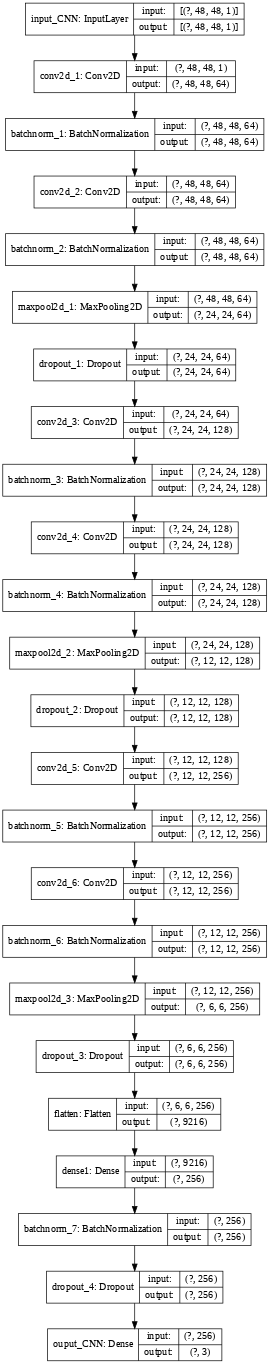

In [78]:
model = build_cnn(INPUT_SHAPE, NUM_CLASSES, show_summary=False)
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True,
           dpi=50,)# to_file=BASE_PATH+'cnn.png')

In [0]:
train_datagen_1 = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)

train_datagen_2 = ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.08,
    height_shift_range=0.08,
    shear_range=0.1,
    horizontal_flip=True,
)

In [0]:
early_stopping_1 = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

early_stopping_2 = EarlyStopping(
    monitor='accuracy',
    min_delta=0.0005,
    patience=15,
    verbose=1,
    restore_best_weights=True,
)

In [0]:
lr_scheduler_1 = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.4,
    patience=5,
    min_lr=1e-7,
    verbose=1,
)

lr_scheduler_2 = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.5,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

lr_scheduler_3 = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.2,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

In [0]:
if "fer_aligned" in DATA:
    BEST_CONFIG = {
        "batch_size": 20,
        "epochs": 65,
        "loss": "categorical_crossentropy",
        "optim": optimizers.Adam(0.01),
        "train_datagen": train_datagen_2,
        "callbacks": [lr_scheduler_3, early_stopping_1],
    }
else:
    BEST_CONFIG = {
        "batch_size": 12,
        "epochs": 100,
        "loss": "categorical_crossentropy",
        "optim": optimizers.Adam(0.01),
        "train_datagen": train_datagen_1,
        "callbacks": [lr_scheduler_2, early_stopping_2],
    }

In [83]:
model.compile(
        loss=BEST_CONFIG["loss"],
        optimizer=BEST_CONFIG["optim"],
        metrics=['accuracy']
)

BEST_CONFIG["train_datagen"].fit(X_train)
history = model.fit(
    BEST_CONFIG["train_datagen"].flow(X_train, y_train, batch_size=BEST_CONFIG["batch_size"]),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / BEST_CONFIG["batch_size"],
    epochs=BEST_CONFIG["epochs"],
    callbacks=BEST_CONFIG["callbacks"],
)

Epoch 1/65
185/184 [==============================] - 3s 14ms/step - loss: 1.4314 - accuracy: 0.4283 - val_loss: 1.3527 - val_accuracy: 0.5487 - lr: 0.0100
Epoch 2/65
185/184 [==============================] - 2s 12ms/step - loss: 1.0499 - accuracy: 0.5231 - val_loss: 1.9934 - val_accuracy: 0.3280 - lr: 0.0100
Epoch 3/65
185/184 [==============================] - 2s 12ms/step - loss: 0.9840 - accuracy: 0.5472 - val_loss: 0.9051 - val_accuracy: 0.5348 - lr: 0.0100
Epoch 4/65
185/184 [==============================] - 2s 12ms/step - loss: 0.8244 - accuracy: 0.6232 - val_loss: 0.7660 - val_accuracy: 0.6600 - lr: 0.0100
Epoch 5/65
185/184 [==============================] - 2s 12ms/step - loss: 0.7567 - accuracy: 0.6452 - val_loss: 0.6414 - val_accuracy: 0.7038 - lr: 0.0100
Epoch 6/65
185/184 [==============================] - 2s 12ms/step - loss: 0.6988 - accuracy: 0.6805 - val_loss: 0.7269 - val_accuracy: 0.6501 - lr: 0.0100
Epoch 7/65
185/184 [==============================] - 2s 12ms/st

In [0]:
model.save(BASE_PATH+f"dumps/cnn_{DATA}_{NUM_CLASSES}emo.h5")

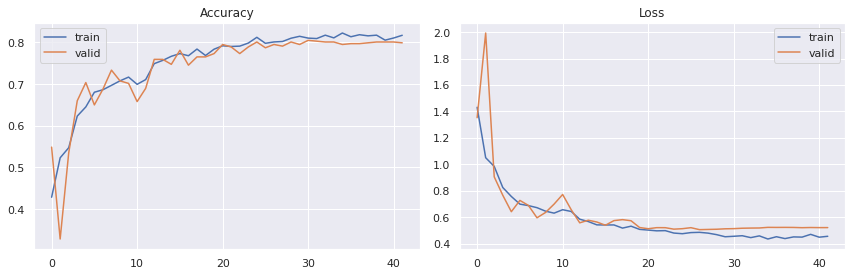

In [101]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig(BASE_PATH+f'epoch_metrics/cnn_{DATA}_{NUM_CLASSES}emo.png')
pyplot.show()

In [85]:
label_to_text

{0: 'Happy', 1: 'Sadness', 2: 'Neutral'}

test accuracy: 80.5169 %


              precision    recall  f1-score   support

           0       0.92      0.89      0.91       232
           1       0.76      0.71      0.73       126
           2       0.68      0.75      0.71       145

    accuracy                           0.81       503
   macro avg       0.79      0.78      0.78       503
weighted avg       0.81      0.81      0.81       503



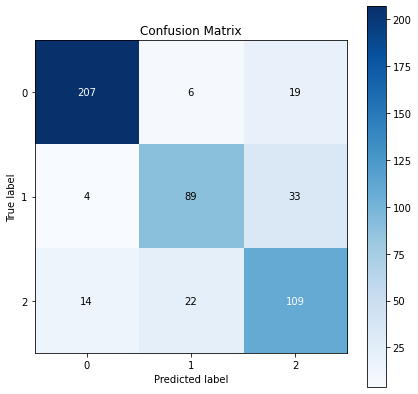

In [100]:
yhat_test = np.argmax(model.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
pyplot.savefig(BASE_PATH+f"confusion_matrix/cnn_{DATA}_{NUM_CLASSES}emo.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))

In [87]:
yhat_train = np.argmax(model.predict(X_train), axis=1)
ytrain_ = np.argmax(y_train, axis=1)

train_accu = np.sum(ytrain_ == yhat_train) / len(ytrain_) * 100
print(f"train accuracy: {round(train_accu, 4)} %")

train accuracy: 85.2877 %


### Visualizing the Model

In [88]:
X_test[0].shape

(48, 48, 1)

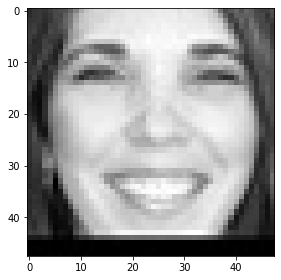

In [89]:
sns.reset_orig()

img = X_test[0]
ax = pyplot.subplot(1,1,1)
ax.imshow(img.reshape(48,48), cmap="gray")
pyplot.tight_layout()

In [90]:
img = np.expand_dims(img, axis=0)
img.shape

(1, 48, 48, 1)

In [91]:
layer_list = [(layer.name, layer) for layer in model.layers if "conv" in layer.name]
layer_list

[('conv2d_1',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7fa4467a3320>),
 ('conv2d_2',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7fa44a2e62e8>),
 ('conv2d_3',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7fa4c0ee65f8>),
 ('conv2d_4',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7fa4465dcef0>),
 ('conv2d_5',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7fa4c0f76a58>),
 ('conv2d_6',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7fa446780278>)]

In [0]:
INTERESTED_LAYERS = [f"conv2d_{i}" for i in range(1,7)]

#### Let's visualize feature maps

CPU times: user 53.5 s, sys: 717 ms, total: 54.2 s
Wall time: 53.4 s


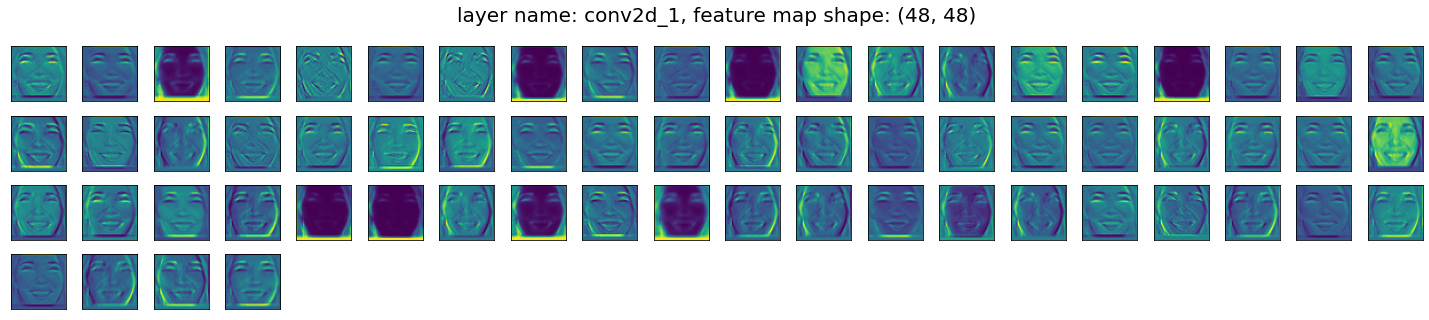

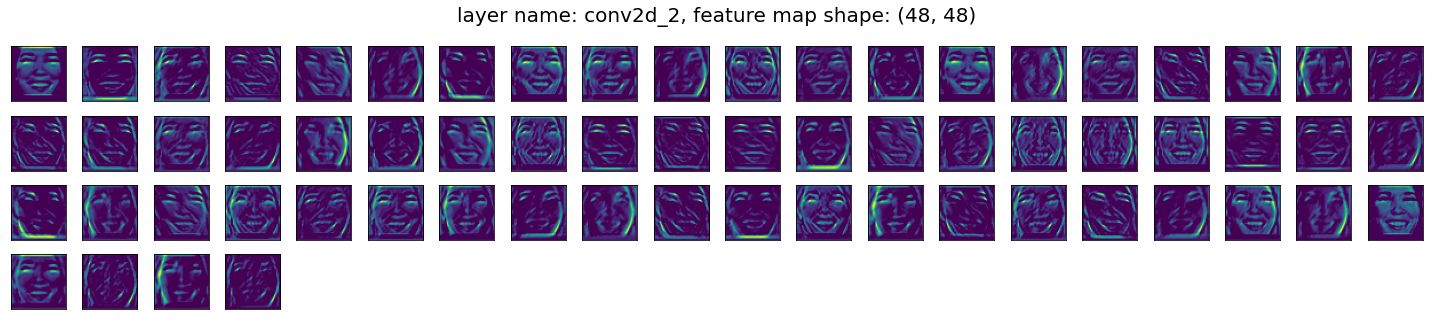

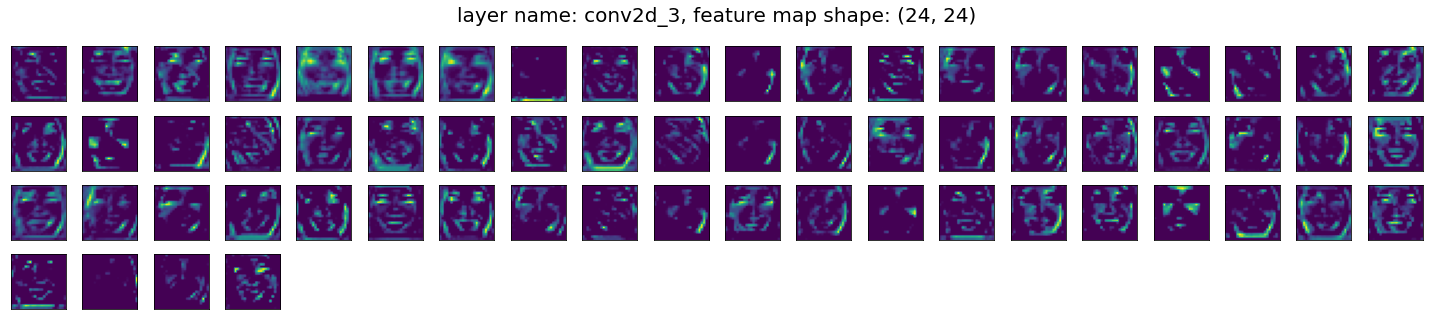

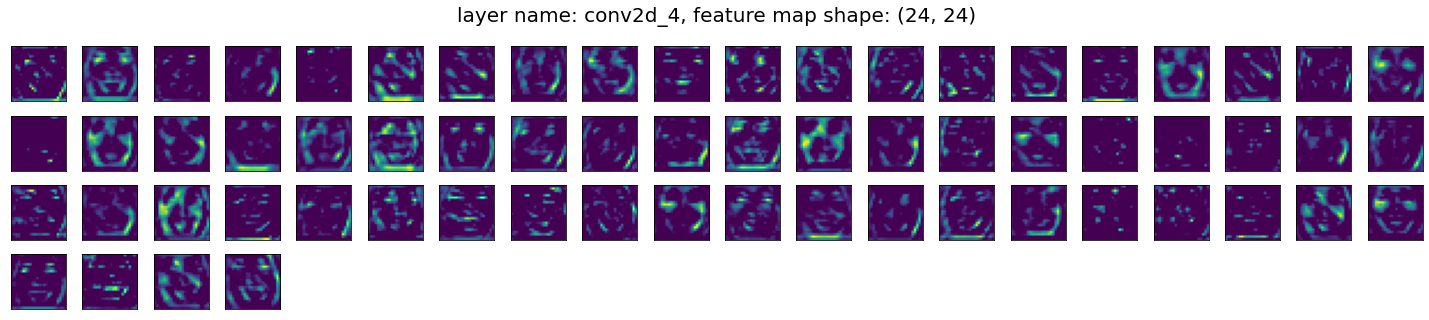

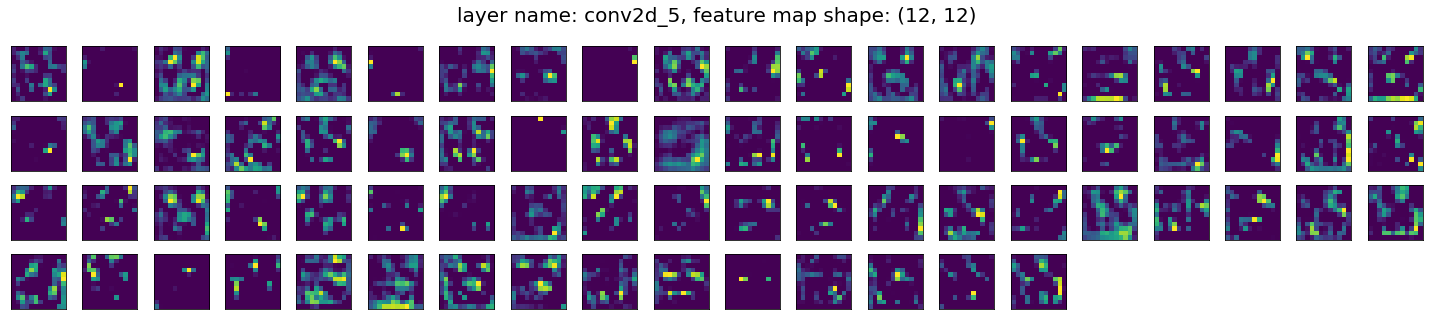

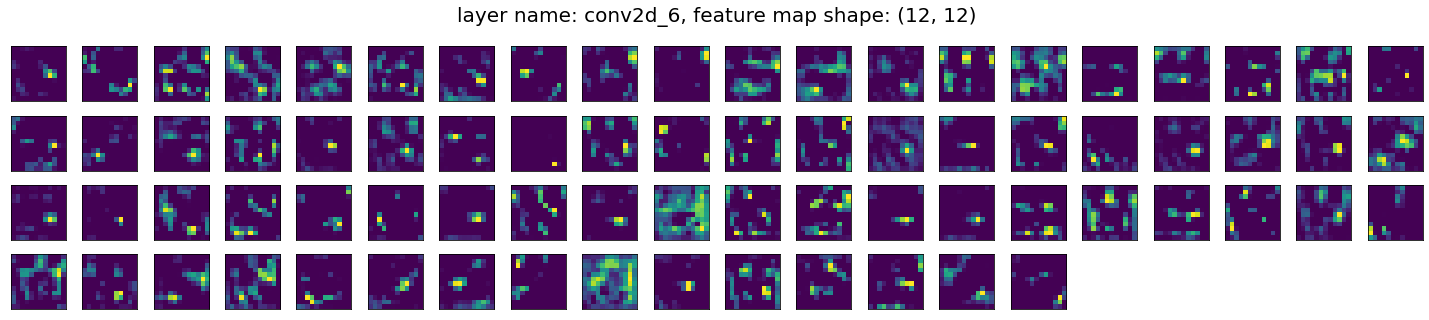

In [93]:
%%time

i = 1
for layer in layer_list:
    if layer[0] in INTERESTED_LAYERS:
        model_conv2d = Model(inputs=model.inputs, outputs=layer[1].output)
        featuremaps_conv2d = model_conv2d.predict(img)
        num_featuremaps = featuremaps_conv2d.shape[3]

        if num_featuremaps <= 64:
            pass
        elif num_featuremaps <= 128:
            sample_fm = np.random.choice(range(num_featuremaps), size=64, replace=False)
            featuremaps_conv2d = featuremaps_conv2d[:,:,:,sample_fm]
        else:
            sample_fm = np.random.choice(range(num_featuremaps), size=75, replace=False)
            featuremaps_conv2d = featuremaps_conv2d[:,:,:,sample_fm]
        
        cols = 20
        rows = math.ceil(featuremaps_conv2d.shape[-1] / cols)

        fig = pyplot.figure(i, (cols, rows))
        i += 1
        
        for idx, feature_map in enumerate(np.rollaxis(featuremaps_conv2d, axis=3)):
            ax = pyplot.subplot(rows, cols ,idx+1)
            ax.imshow(feature_map[0], cmap="viridis")
            ax.set_xticks([])
            ax.set_yticks([])
            pyplot.suptitle(f"layer name: {layer[0]}, feature map shape: {featuremaps_conv2d.shape[1:3]}", fontsize=20, y=1.1)
            pyplot.tight_layout()

#### Let's plot Class Activation Map (CAM)

In [94]:
preds = model.predict(img)
label_to_text[np.argmax(preds[0])]

'Happy'

In [95]:
pred_vector_output = model.output[:, np.argmax(preds[0])]
pred_vector_output

<tf.Tensor 'strided_slice:0' shape=(None,) dtype=float32>

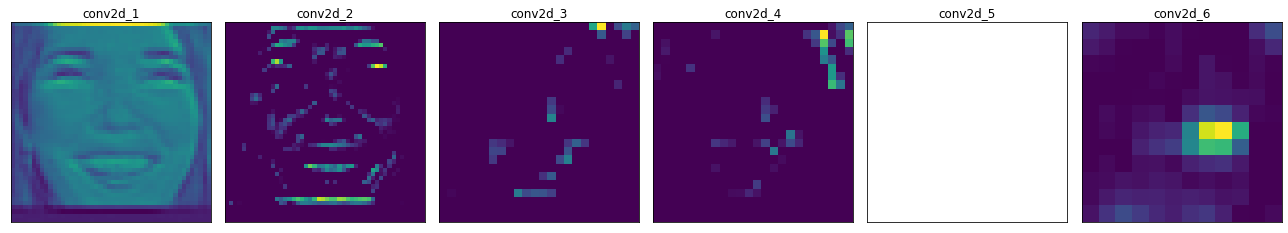

In [96]:
heatmaps = []
for layer in layer_list:
    if layer[0] in INTERESTED_LAYERS:
        some_conv_layer = model.get_layer(layer[0])
        grads = K.gradients(pred_vector_output, some_conv_layer.output)[0]
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
        iterate = K.function([model.input], [pooled_grads, some_conv_layer.output[0]])
        pooled_grads_value, conv_layer_output_value = iterate([img])

        for i in range(model.get_layer(layer[0]).output_shape[-1]):
            conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

        heatmaps.append(np.mean(conv_layer_output_value, axis=-1))

fig = pyplot.figure(figsize=(18, 4))

for i, (name,hm) in enumerate(zip(INTERESTED_LAYERS, heatmaps)):
    ax = pyplot.subplot(1, len(INTERESTED_LAYERS), i+1)
    img_heatmap = np.maximum(hm, 0)
    img_heatmap /= np.max(img_heatmap)
    ax.imshow(img_heatmap, cmap="viridis")
    ax.set_xticks([])
    ax.set_yticks([])
    pyplot.title(name)
    pyplot.tight_layout()

pyplot.show()

#### Let's see some results

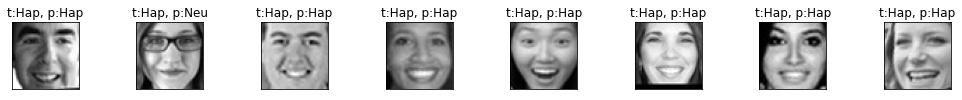

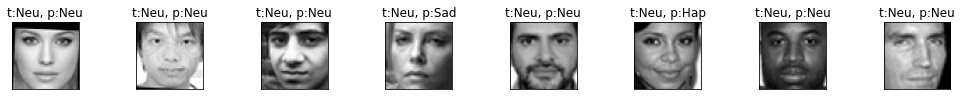

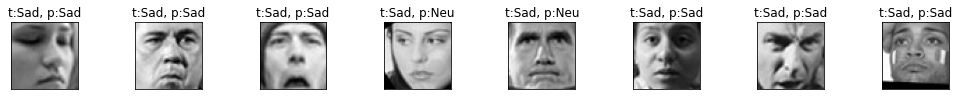

In [97]:
f = 1
for emotion in TOP_EMOTIONS:
    emotion_imgs = np.random.choice(np.where(y_test[:, text_to_label[emotion]]==1)[0], size=8, replace=False)

    pyplot.figure(f, (16,1.5))
    f += 1

    for i,img_idx in enumerate(emotion_imgs):
        sample_img = X_test[img_idx,:,:,0]
        pred = label_to_text[np.argmax(model.predict(sample_img.reshape(1,48,48,1)), axis=1)[0]]
        ax = pyplot.subplot(1, 9, i+1)
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:{emotion[:3]}, p:{pred[:3]}")
        pyplot.tight_layout()

#### Let's visualize the mistakes made by our model

In [0]:
def plot_miss_classified(emotion,fig):
    miss_indices = np.where((ytest_ != yhat_test) & (ytest_==text_to_label[emotion]))[0]

    if len(miss_indices) > 0:
        cols = 15
        rows = math.ceil(len(miss_indices) / cols)
        pyplot.figure(fig, (20, rows*1.5))

        for i,idx in enumerate(miss_indices):
            sample_img = X_test[idx,:,:,0]
            pred = label_to_text[np.argmax(model.predict(sample_img.reshape(1,48,48,1)), axis=1)[0]]
            ax = pyplot.subplot(rows,cols,i+1)
            ax.imshow(sample_img, cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f"p:{pred}")
            pyplot.suptitle(f"total {len(miss_indices)} miss labels out of {len(np.where(ytest_==text_to_label[emotion])[0])} for emotion {emotion}", y=1, fontsize=16)

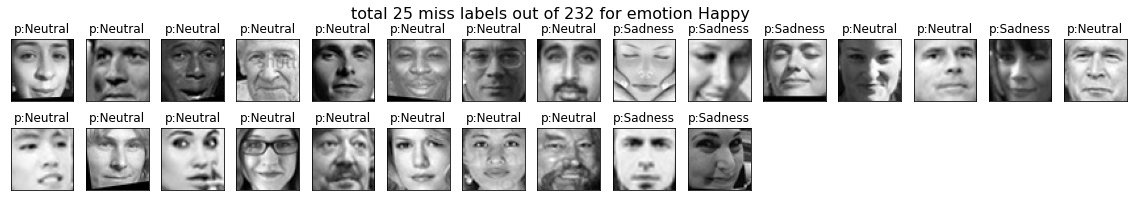

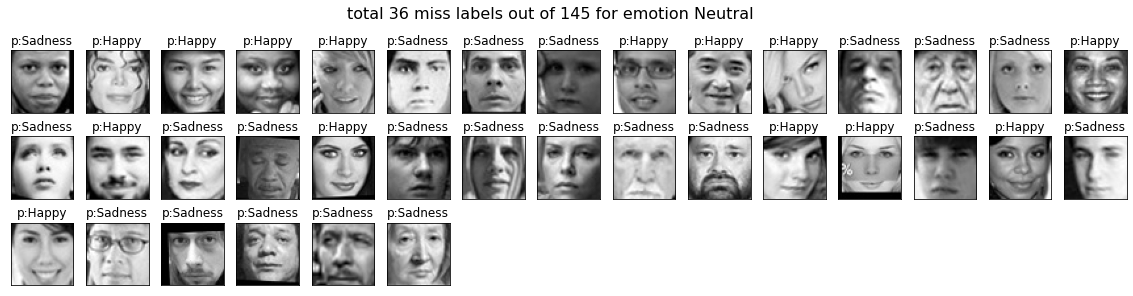

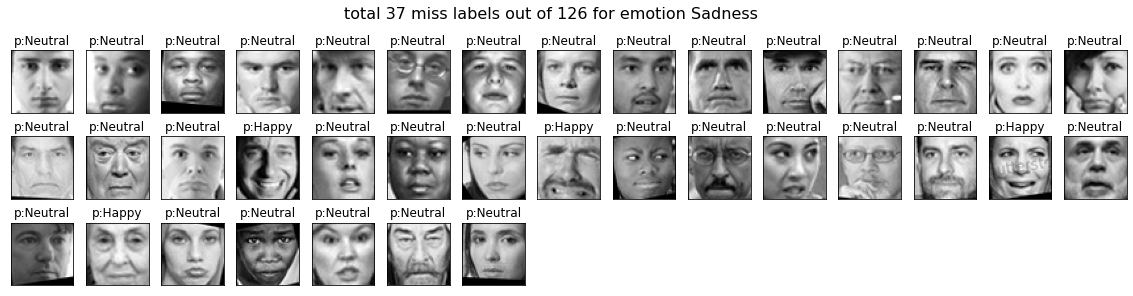

In [99]:
for fig,emotion in enumerate(TOP_EMOTIONS):
    plot_miss_classified(emotion, fig)